Train: (125973, 43)
Test : (22544, 43)

KNN (k=5)
[[9018  693]
 [4482 8351]]
              precision    recall  f1-score   support

           0     0.6680    0.9286    0.7770      9711
           1     0.9234    0.6507    0.7635     12833

    accuracy                         0.7704     22544
   macro avg     0.7957    0.7897    0.7702     22544
weighted avg     0.8134    0.7704    0.7693     22544



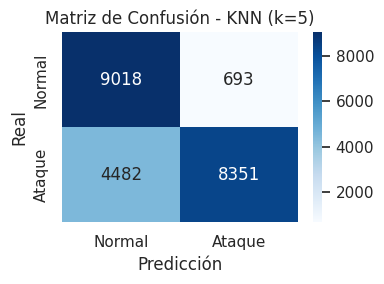


Decision Tree
[[9434  277]
 [4568 8265]]
              precision    recall  f1-score   support

           0     0.6738    0.9715    0.7957      9711
           1     0.9676    0.6440    0.7733     12833

    accuracy                         0.7851     22544
   macro avg     0.8207    0.8078    0.7845     22544
weighted avg     0.8410    0.7851    0.7830     22544



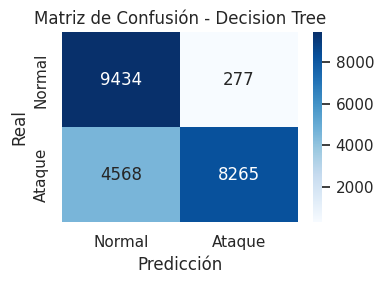


SVM RBF
[[9007  704]
 [4099 8734]]
              precision    recall  f1-score   support

           0     0.6872    0.9275    0.7895      9711
           1     0.9254    0.6806    0.7843     12833

    accuracy                         0.7869     22544
   macro avg     0.8063    0.8040    0.7869     22544
weighted avg     0.8228    0.7869    0.7866     22544



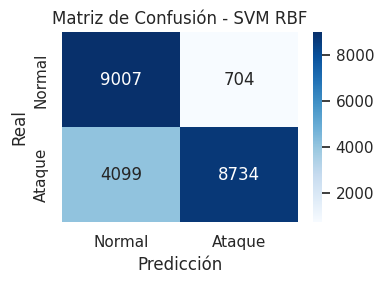


SVM Lineal
[[8970  741]
 [4877 7956]]
              precision    recall  f1-score   support

           0     0.6478    0.9237    0.7615      9711
           1     0.9148    0.6200    0.7391     12833

    accuracy                         0.7508     22544
   macro avg     0.7813    0.7718    0.7503     22544
weighted avg     0.7998    0.7508    0.7487     22544



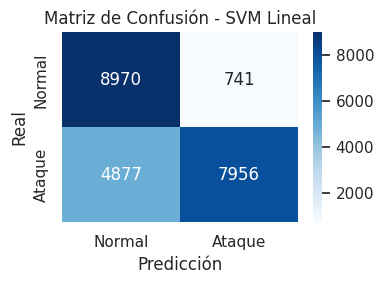

,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC,Train_time_s
2,SVM RBF,0.786950,0.925408,0.680589,0.784338,0.904271,973.389812
1,Decision Tree,0.785087,0.967572,0.644043,0.773333,0.762042,1.158753
0,KNN (k=5),0.770449,0.923375,0.650744,0.763450,0.819669,0.100339
3,SVM Lineal,0.750798,0.914798,0.619964,0.739062,0.806615,2470.495129


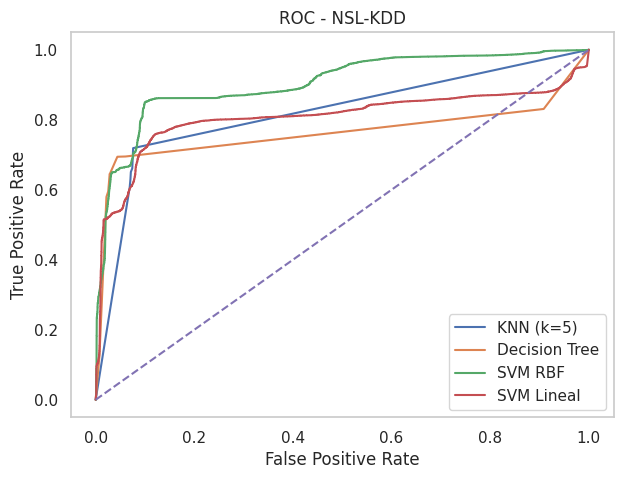

In [1]:

# 1) Dependencias
!pip install -q scikit-learn pandas matplotlib seaborn

import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
    "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label","difficulty"
]



# 5) Cargar datos
df_train = pd.read_csv("/content/KDDTrain+.txt", names=columns)
df_test  = pd.read_csv("/content/KDDTest+.txt",  names=columns)

print("Train:", df_train.shape)
print("Test :", df_test.shape)

# 6) Preprocesamiento
# 6.1 Etiqueta binaria
df_train["label_binary"] = df_train["label"].apply(lambda x: 0 if x == "normal" else 1)
df_test["label_binary"]  = df_test["label"].apply(lambda x: 0 if x == "normal" else 1)

# 6.2 Eliminar columnas no usadas
df_train.drop(columns=["label","difficulty"], inplace=True)
df_test.drop(columns=["label","difficulty"], inplace=True)

# 6.3 One-hot encoding
categorical_cols = ["protocol_type","service","flag"]
df_all = pd.concat([df_train, df_test], axis=0)
df_all = pd.get_dummies(df_all, columns=categorical_cols)

# Separar nuevamente
df_train_enc = df_all.iloc[:len(df_train)]
df_test_enc  = df_all.iloc[len(df_train):]

X_train = df_train_enc.drop(columns=["label_binary"])
y_train = df_train_enc["label_binary"]
X_test  = df_test_enc.drop(columns=["label_binary"])
y_test  = df_test_enc["label_binary"]

# 6.4 Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 7) Modelos
models = {
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "SVM RBF": SVC(kernel="rbf", probability=True),
    "SVM Lineal": SVC(kernel="linear", probability=True)
}

# 8) Entrenamiento y evaluación
results = []
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Ataque"],
        yticklabels=["Normal", "Ataque"]
    )
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    cm = confusion_matrix(y_test, y_pred)
    results.append({
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Train_time_s": train_time
    })

    print(f"\n{name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    plot_confusion_matrix(cm, name)

# 9) Resultados finales
df_results = pd.DataFrame(results).sort_values("F1", ascending=False)
display(df_results)



# 10) ROC curves
plt.figure(figsize=(7,5))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - NSL-KDD")
plt.legend()
plt.grid()
plt.show()
